In [ ]:
!pip install datasets
!pip install -q torchtext==0.17.2

In [1]:
import os
import re
import string

from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset

from transformer_model import TransformerEncoder

In [ ]:
ds = load_dataset("thainq107/ntc-scv")

## Preprocessing

In [3]:
def preprocess_text(text):
    # Remove URLs https://www.
    url_pattern = re.compile(r"https?://\+\www\.\s+")
    text = url_pattern.sub(r"", text)

    # Remove HTMl tags: <>
    html_pattern = re.compile(r"<[^<>]+>")
    text = html_pattern.sub(" ", text)

    # Remove puncs and digits
    replace_chars = list(string.punctuation + string.digits)
    for char in replace_chars:
        text = text.replace(char, " ")

    # Remove emoji
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # Emoticons
        u"\U0001F300-\U0001F5FF"  # Symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # Transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # Flags
        u"\U00002702-\U000027B0"  # Dingbats
        u"\U000024C2-\U0001F251"  # Enclosed characters
        u"\U0001F926-\U0001F937"  # Additional emoticons
        u"\U0001F1F2"  # Macau flag
        u"\U0001F1F4"  # Specific flag
        u"\U0001F620"  # Angry face
        u"\u200d"      # Zero width joiner
        u"\u2640-\u2642"  # Gender symbols
        "]", flags=re.UNICODE
    )
    text = emoji_pattern.sub(r" ", text)

    # Normalize whitespace
    text = " ".join(text.split())

    # Lowercasting
    text = textlower()
    return text


def yield_tokens(sentences, tokenizer):
    for sentence in sentences:
        yield tokenizer(sentence)


def prepare_dataset(df):
    # Create iterator for dataset (sentence, label)
    for row in df:
        sentence = row["preprocessed_sentence"]
        encoded_sentence = vocabulary(tokenizer(sentence))
        label = row["label"]
        yield encoded_sentence, label


### Representation

In [4]:
tokenizer = get_tokenizer("basic_english")

vocab_size = 10000
vocabulary = build_vocab_from_iterator(
    yield_tokens(ds["train"]["preprocessed_sentence"], tokenizer),
    max_tokens=vocab_size,
    specials=["<pad>", "<unk>"]
)
vocabulary.set_default_index(vocabulary["<unk>"])

In [5]:
train_dataset = prepare_dataset(ds["train"])
train_dataset = to_map_style_dataset(train_dataset)

valid_dataset = prepare_dataset(ds["valid"])
valid_dataset = to_map_style_dataset(valid_dataset)

test_dataset = prepare_dataset(ds["test"])
test_dataset = to_map_style_dataset(test_dataset)

In [6]:
len(train_dataset), len(valid_dataset), len(test_dataset)

(30000, 10000, 10000)

### DataLoader

In [7]:
seq_length = 100

def collate_batch(batch):
    # Create inputs, offsets, lebels for batch
    sentences, labels = list(zip(*batch))
    encoded_sentences = [
        sentence + ([0] * (seq_length - len(sentence))) if len(sentence) < seq_length else sentence[:seq_length]
        for sentence in sentences
    ]

    encoded_sentences = torch.tensor(encoded_sentences, dtype=torch.int64)
    labels = torch.tensor(labels)
    return encoded_sentences, labels

In [8]:
batch_size = 128

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_batch
)

valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_batch
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_batch
)

len(train_dataloader), len(valid_dataloader), len(test_dataloader)

(235, 79, 79)

## Model Setup and Workflow

### Model Training, Evaluation, and Plotting Functions

In [9]:
def train_epoch(model, optimizer, criterion, dataloader, device, epoch=0, log_interval=50):
    model.train()

    total_acc, total_count = 0, 0
    losses = []
    for idx, (inputs, labels) in enumerate(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        preds = model(inputs)
        loss = criterion(preds, labels) # Calculate loss
        losses.append(loss.item())

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        total_acc += (preds.argmax(1) == labels).sum().item()
        total_count += labels.size(0)

        # Log progress
        if idx % log_interval == 0 and idx > 0:
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches | accuracy {:8.3f}".format(
                    epoch, idx, len(dataloader), total_acc / total_count
                )
            )
            total_acc, total_count = 0, 0

    # Calculate epoch metrics
    epoch_acc = total_acc / total_count
    epoch_loss = np.mean(losses)

    return epoch_acc, epoch_loss


def evaluate_epoch(model, criterion, dataloader, device):
    model.eval()

    total_acc, total_count = 0, 0
    losses = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)

            preds = model(inputs)
            loss = criterion(preds, labels)
            losses.append(loss.item())

            total_acc += (preds.argmax(1) == labels).sum().item()
            total_count += labels.size(0)

    epoch_acc = total_acc / total_count
    epoch_loss = np.mean(losses)

    return epoch_acc, epoch_loss

In [10]:
def train(model, model_name, save_model, optimizer, criterion, train_dataloader, valid_dataloader, num_epochs, device):
    train_accs, train_losses = [], []
    eval_accs, eval_losses = [], []

    best_lost_eval = 100

    for epoch in range(1, num_epochs + 1):

        # Training
        train_acc, train_loss = train_epoch(model, optimizer, criterion, train_dataloader, device)
        train_accs.append(train_acc)
        train_losses.append(train_loss)

        # Evaluation
        eval_acc, eval_loss = evaluate_epoch(model, criterion, valid_dataloader, device)
        eval_accs.append(eval_acc)
        eval_losses.append(eval_loss)

        # Save best model
        if eval_loss < best_lost_eval:
            best_lost_eval = eval_loss
            torch.save(model.state_dict(), save_model + f"/{model_name}.pt")

        # Log progress
        print("=" * 50)
        print("| End of epoch {:3d} | Train Accuracy {:8.3f} | Train Loss {:8.3f} | Valid Accuracy {:8.3f} | Valid Loss {:8.3f}".format(epoch, train_acc, train_loss, eval_acc, eval_loss))
        print("=" * 50)

    # Load best model
    model.load_state_dict(torch.load(save_model + f"/{model_name}.pt"))
    model.eval()
    return model, train_accs, train_losses, eval_accs, eval_losses

In [24]:
def plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    ax[0].plot(num_epochs, train_accs, label="Training")
    ax[0].plot(num_epochs, eval_accs, label="Evaluation")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(num_epochs, train_losses, label="Training")
    ax[1].plot(num_epochs, eval_losses, label="Evaluation")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Loss")

    plt.legend()
    plt.show()

### Transformer Encoder Classifier

In [15]:
class TransformerEncoderCls(nn.Module):
    def __init__(self, vocab_size, max_length, num_layers, embed_dim, num_heads, ff_dim, dropout=0.1, device="cpu"):
        super().__init__()
        self.encoder = TransformerEncoder(vocab_size, embed_dim, max_length, num_layers, num_heads, ff_dim, dropout, device)
        self.pooling = nn.AvgPool1d(kernel_size=max_length)
        self.fc1 = nn.Linear(in_features=embed_dim, out_features=20)
        self.fc2 = nn.Linear(in_features=20, out_features=2)
        self.dropout = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        output = self.encoder(x)
        output = self.pooling(output.permute(0, 2, 1)).squeeze()
        output = self.dropout(output)
        output = self.fc1(output)
        output = self.dropout(output)
        output = self.fc2(output)
        return output

## Train

In [17]:
vocab_size = 10000
max_length = 100
embed_dim = 200
num_layers = 2
num_heads = 4
ff_dim = 128
dropout = 0.1
device = torch.device("cuda" if torch.cuda.is_available else "cpu")

model = TransformerEncoderCls(vocab_size, max_length, num_layers, embed_dim, num_heads, ff_dim, dropout, device).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005)

In [18]:
num_epochs = 50
model_name = "transformer"
save_model = "./model"
os.makedirs(save_model, exist_ok=True)

model, train_accs, train_losses, eval_accs, eval_losses = train(model, model_name, save_model, optimizer, criterion, train_dataloader, valid_dataloader, num_epochs, device)

| epoch   0 |    50/  235 batches | accuracy    0.549
| epoch   0 |   100/  235 batches | accuracy    0.603
| epoch   0 |   150/  235 batches | accuracy    0.693
| epoch   0 |   200/  235 batches | accuracy    0.740
| End of epoch   1 | Train Accuracy    0.749 | Train Loss    0.626 | Valid Accuracy    0.763 | Valid Loss    0.512
| epoch   0 |    50/  235 batches | accuracy    0.774
| epoch   0 |   100/  235 batches | accuracy    0.783
| epoch   0 |   150/  235 batches | accuracy    0.794
| epoch   0 |   200/  235 batches | accuracy    0.796
| End of epoch   2 | Train Accuracy    0.785 | Train Loss    0.467 | Valid Accuracy    0.796 | Valid Loss    0.450
| epoch   0 |    50/  235 batches | accuracy    0.810
| epoch   0 |   100/  235 batches | accuracy    0.807
| epoch   0 |   150/  235 batches | accuracy    0.804
| epoch   0 |   200/  235 batches | accuracy    0.806
| End of epoch   3 | Train Accuracy    0.814 | Train Loss    0.428 | Valid Accuracy    0.799 | Valid Loss    0.439
| epoch

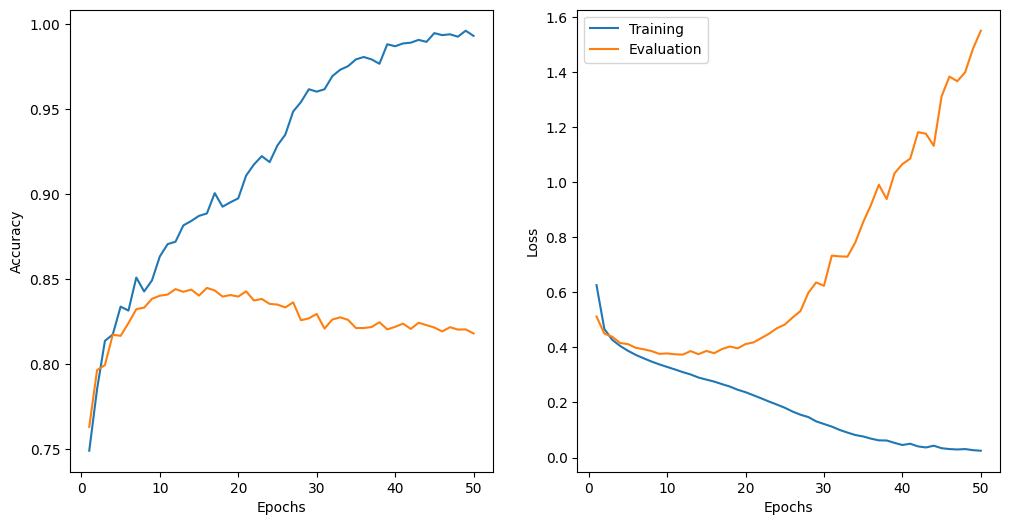

In [30]:
num_epochs = np.arange(1, 51)

plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses)

## Evaluation

In [34]:
val_acc, eval_loss = evaluate_epoch(model, criterion, valid_dataloader, device)
test_acc, test_loss = evaluate_epoch(model, criterion, test_dataloader, device)

print("Evaluation on val/test dataset")
print("Val acc: ", val_acc)
print("Test acc: ", test_acc)

Evaluation on val/test dataset
Val acc:  0.8441
Test acc:  0.8455
